In [29]:
#Reference: Heng CherKeng https://storage.googleapis.com/kaggle-forum-message-attachments/345216/9642/train.py
    
import os
import sys
import math
import datetime
from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as time
from keras import models
from keras.models import load_model
from keras.utils import multi_gpu_model
from keras import layers
from keras import backend as K
from keras.layers import Masking
from keras import optimizers


In [24]:
TRAIN_DATA = '../../../../kaggle-trackml/input/train_1'
TRAIN_NUMPY = '../../../../kaggle-trackml/input/train_numpy'
TRAIN_SAMPLE_DATA = '../../../../kaggle-trackml/input/train_100_events'
DBSCAN_DATA = '../../../../kaggle-trackml/input'
GPU = 0 # 0 is default (usually uses 1 GPU if available, if > 1 then configures multi-gpu model)
# Pass in saved model file name if desired, i.e "2018-11-16-01-13-33.h5". If set to None,
# a new model will be built.
LOAD_MODEL_NAME = None
TRAIN_MODEL = False # Model is automatically saved after training
VISUALIZE_RESULTS = False

In [3]:
def test_gpu():
    found_gpus = K.tensorflow_backend._get_available_gpus()
    print("Found GPUs: {}".format(found_gpus))

In [4]:
def draw_train_history(history, metric='acc', metric_ylabel='Accuracy', metric_title='Training accuracy', draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    fig = plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history[metric], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history["val_" + metric], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel(metric_ylabel)
    plt.ylim((0, 1))
    plt.title(metric_title)
    plt.legend(loc=0)
    plt.tight_layout()
    return fig


def draw_prediction_2d(truth, predict, start=0, end=1):
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(2,1,1)
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    
    fig2 = plt.figure(figsize=(12,12))
    ax2 = fig2.add_subplot(2,1,1)
    ax2.set_xlabel('a', fontsize=16)
    ax2.set_ylabel('r', fontsize=16)
    
    for n in range(start,end,1):
        a, r, z = truth[n].T
        x = r*np.cos(a)
        y = r*np.sin(a)
        ea, er, ez = predict[n].T
        ex = er*np.cos(ea)
        ey = er*np.sin(ea)
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,'.-',color = color, markersize=5)
        
        ax2.plot(ea,er,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax2.plot(a,r,'.-',color = color, markersize=5)

    
def draw_prediction(truth, predict, start=0, end=1):
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)

    fig2 = plt.figure(figsize=(12,12))
    ax2  = fig2.add_subplot(111, projection='3d')
    fig2.patch.set_facecolor('white')
    ax2.set_xlabel('a', fontsize=16)
    ax2.set_ylabel('r', fontsize=16)
    ax2.set_zlabel('z', fontsize=16)

    for n in range(start,end,1):
        a, r, z, v = truth[n].T
        x = r*1000*np.cos(a)
        y = r*1000*np.sin(a)
        z = z*3000
        
        ea, er, ez, ev = predict[n].T
        ex = er*1000*np.cos(ea)
        ey = er*1000*np.sin(ea)
        ez = ez*3000
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        
        ax2.plot(ea,er,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax2.plot(a,r,z,'.-',color = color, markersize=5)
        if n==50: plt.show(1)


In [31]:
#import keras.backend as K

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))

def compile_model(model, loss, optimizer, metrics):
    if GPU > 0:
        gpu_model = multi_gpu_model(model, GPU)
    else:
        gpu_model = model
 
    gpu_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
 
    return model, gpu_model

def load_existing_model(filename, loss='mse', optimizer='Nadam', metrics=['accuracy', 'mae', 'mape']):
    model = load_model(filename)
    return compile_model(model, loss, optimizer, metrics)

def build_new_model(input_shape, output_shape,
                loss='mse', #loss='mae', # loss=rmse
                optimizer='Nadam', metrics=['accuracy', 'mae', 'mape']):
    inputs = layers.Input(shape=input_shape)
    hidden = layers.LSTM(units=512, return_sequences=True)(inputs)
    dropout = layers.Dropout(0.2)(hidden)
    hidden2 = layers.LSTM(units=512, return_sequences=True)(dropout)
    outputs = layers.TimeDistributed(layers.Dense(output_shape[1], activation='linear'))(hidden2)
    model = models.Model(inputs=inputs, outputs=outputs)

    return compile_model(model, loss, optimizer, metrics)


In [6]:
def generate_dbscan_tracks(labels, hits):
    labels = np.copy(labels)
    hits['z_abs'] = hits.z.abs()
    all_tracks = np.unique(labels)
    filtered_tracks = []
    seeded_tracks = []
    truth_tracks = []
    
    
    count_extended = 0
    for track in all_tracks:
        if track == 0:
            continue
        track_hits = np.where(labels == track)[0]
        if len(track_hits) < 10: continue
        tdf = hits.loc[track_hits]
        if (tdf.x <= 0).any(): continue
        if (tdf.y <= 0).any(): continue
        #if (tdf.z <= 0).any(): continue
        tdf = tdf.sort_values('r')
        each_track = np.zeros((10,2))
        seeded_track = np.zeros((5,2))
        truth_track = np.zeros((10,2))
        for i in range(10):
            if i < 5:
#                 each_track[i]=([tdf.a.values[i], tdf.r.values[i]/1000, tdf.z.values[i]/3000])
#                 seeded_track[i]=([tdf.a.values[i], tdf.r.values[i]/1000, tdf.z.values[i]/3000])
                each_track[i]=([tdf.a.values[i], tdf.r.values[i]/1000])
                seeded_track[i]=([tdf.a.values[i], tdf.r.values[i]/1000])
                
            #truth_track[i]=([tdf.a.values[i], tdf.r.values[i]/1000, tdf.z.values[i]/3000])
            truth_track[i]=([tdf.a.values[i], tdf.r.values[i]/1000])
           
        filtered_tracks.append(each_track)
        seeded_tracks.append(seeded_track)
        truth_tracks.append(truth_track)
        
        
    return np.array(filtered_tracks), np.array(seeded_tracks), np.array(truth_tracks)

def generate_dbscan_test_data(event_id):
    helix1 = pd.read_csv(os.path.join(DBSCAN_DATA, 'event_%s_labels_train_helix1.csv' %event_id)).label.values
    hits = load_one_test_event_data('00000' + "{:04}".format(event_id), path=TRAIN_SAMPLE_DATA)   
    hits = generate_df(hits, False)
    return generate_dbscan_tracks(helix1, hits)


In [7]:
def load_one_test_event_data(event_id, path):
    hits  = pd.read_csv(os.path.join(path, 'event%s-hits.csv' %event_id))
    cells = pd.read_csv(os.path.join(path, 'event%s-cells.csv'%event_id))
    return hits

def generate_df(df, filter=True):
    df = df.copy()
    if filter is True:
        df = df.loc[ (df.x>0) & (df.y>0) & (df.z>0) ]
        #df = df.loc[ (df.x>0) & (df.y>0) ]
        
    df = df.assign(r   = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(a   = np.arctan2(df.y, df.x))
    df = df.assign(z1 = df.z/df.r)
    # Other possible features that can be evaluated?
    #df = df.assign(d   = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    #df = df.assign(cosa= np.cos(df.a))
    #df = df.assign(sina= np.sin(df.a))
    #df = df.assign(phi = np.arctan2(df.z, df.r))
    #df = df.assign(z2 = df.z/df.d)
    #df = df.assign(z3 = np.log1p(np.absolute(df.z/df.r))*np.sign(df.z))
    #df = df.assign(xr = df.x/df.r)
    #df = df.assign(yr = df.y/df.r)
    #df = df.assign(xd = df.x/df.d)
    #df = df.assign(yd = df.y/df.d)

    return df

def load_one_event_data(event_id, path=TRAIN_DATA):
    # Only hits and truth data are currently used. May need to merge
    # with the particles or cells data if you want to use those as features.
    #particles = pd.read_csv(os.path.join(path, 'event%s-particles.csv'%event_id))
    hits  = pd.read_csv(os.path.join(path, 'event%s-hits.csv' %event_id))
    truth = pd.read_csv(os.path.join(path, 'event%s-truth.csv'%event_id))
    #cells = pd.read_csv(os.path.join(path, 'event%s-cells.csv'%event_id))
    
    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    #truth = truth.merge(particles,  on=['particle_id'], how='left')
    #truth = truth.merge(cells,      on=['hit_id'],      how='left')

    #--------------------------------------------------------
    df = truth
    return (df)

#TODO x,y,z<0
def generate_train_batch(df):
    df = generate_df(df)

    a,r,z,z1 = df[['a', 'r', 'z', 'z1' ]].values.astype(np.float32).T
    p = df['particle_id'].values.astype(np.int64)
    
    particle_ids = list(df.particle_id.unique())
    num_particle_ids = len(particle_ids)

    # Normalize inputs to a range from 0..1
    incols  = np.column_stack((a,r/1000, z/3000,z1/3))
    
    tracks = []
    
    for particle_id in particle_ids:
        if particle_id==0: continue
        t = np.where(p==particle_id)[0]
        #t = t[np.argsort(r[t])]
        # May need to sort by abs_z?
        t = t[np.argsort(z[t])]

        # For simplicity for now, only train tracks >= 10 hits,
        # and truncate to exactly 10 hits.
        if len(t)<10: continue
        track = incols[t[:10]]
        tracks.append(track)

    tracks = np.array(tracks)
    incols = tracks[:,:5,:]
    incols = np.pad(incols, ((0,0),(0,5), (0,0)), 'constant')
   
    truth  = tracks[:,:,:]

    return (df, incols, truth)


def batch_generator(invals, truth, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, invals.shape[0], invals.shape[1]))
    batch_labels =  np.zeros((batch_size, truth.shape[0], truth.shape[1]))
    index = 0
   
    while True:
        batch_features = invals[batch_size*index:batch_size*(index+1),:,:]
        batch_labels = truth[batch_size*index:batch_size*(index+1),:,:]
        index = index+1
        if batch_size*index > invals.shape[0]:
            index=0
      
        yield batch_features, batch_labels

def generate_multiple_event_data(skip=0, nevents=10):
    start = 1000
    invals = None
    truth = None
    for i in range(nevents):
        try:
            df = load_one_event_data('00000' + "{:04}".format(start+skip+i))
            df, input_tmp, truth_tmp = generate_train_batch(df)
            if i==0:
                invals = input_tmp
                truth = truth_tmp
            else:
                invals = np.concatenate([invals, input_tmp])
                truth = np.concatenate([truth, truth_tmp])
        except:
            pass

    return invals, truth


In [8]:
def load_or_generate_multiple_event_data(skip=0, nevents=10):
    print("Generating or loading x_train, y_train with skip {:04} and nevents {:04}".format(skip, nevents))
    x_train_file = os.path.join(TRAIN_NUMPY, "event_skip_{:04}_nevents_{:04}".format(skip, nevents)+'_x_train.npy')
    y_train_file = os.path.join(TRAIN_NUMPY, "event_skip_{:04}_nevents_{:04}".format(skip, nevents)+'_y_train.npy')

    if os.path.exists(x_train_file):
        x_train = np.load(x_train_file)
        y_train = np.load(y_train_file)
    else:
        # This may take 1+ hour, once it's finished, save processed events as a numpy
        # array, which can be loaded in a few milliseconds
        print('Generating event data, this will take a long time...')
        x_train, y_train = generate_multiple_event_data(skip=skip, nevents=nevents)
        np.save(x_train_file, x_train)
        np.save(y_train_file, y_train)

    return x_train, y_train

In [9]:
def generate_train_batch_for_fitting(df):
    df = generate_df(df)
    df['track_id'] = pd.Series([0] * len(df.index), index=df.index)
    df['predict_done'] = pd.Series([0] * len(df.index), index=df.index)
    df['actual_particle_id'] = pd.Series([0] * len(df.index), index=df.index)

    a, r, z, z1, hit, pid, pdone, pactual = df[['a', 'r', 'z', 'z1', 'hit_id', 'particle_id', 'predict_done', 'actual_particle_id' ]].values.astype(np.float32).T
    p = df['particle_id'].values.astype(np.int64)
    
    particle_ids = list(df.particle_id.unique())
    num_particle_ids = len(particle_ids)

    incols  = np.column_stack((a,r/1000, z/3000,z1/3, hit, pid, pdone, pactual))    
    tracks = []
    
    for particle_id in particle_ids:
        if particle_id==0: continue
        t = np.where(p==particle_id)[0]
        t = t[np.argsort(z[t])]

        if len(t)<10: continue
        track = incols[t[:10]]
        tracks.append(track)

    tracks = np.array(tracks)
    incols = tracks[:,:5,:]
    incols = np.pad(incols, ((0,0),(0,5), (0,0)), 'constant')
   
    truth  = tracks[:,:,:]

    return (df, incols, truth)

In [10]:
def fit_predictions(hits, preds):
    """
    Assign predicted LSTM hits to nearest un-assigned hit.
    """
    def do_one_assignment_round(hits, preds):
        labels = hits.track_id.values
        distances = np.zeros((len(labels)), dtype=float)
        predi = np.zeros((len(labels)), dtype=int)
        predj = np.zeros((len(labels)), dtype=int)
        #count_free_hits = len(np.where(labels == 0)[0])
        #print('free hits available this round: ' + str(count_free_hits))

        # Backup current predictions to restore a/rn/zn/zrn values if
        # another hit ends up being closer
        orig_preds = np.copy(preds)

        # Note - df is the list of all available hits not yet assigned to
        # a track. We need to fit our predictions to these hits.
        df = hits.loc[(hits.track_id == 0)]
        hit_ids = df.hit_id.values

        # We have a, r/1000, z/3000, and (z/r)/3
        a, rn, zn, zrn, pid = df[['a', 'rn', 'zn', 'zrn', 'particle_id']].values.T
        tree = KDTree(np.column_stack([a, rn, zn, zrn]), metric='euclidean')

        num_left_to_assign = 0
        # For each predicted track
        for i in range(preds.shape[0]):
            # For each predicted hit in that track
            truth_particle = preds[i,0,5]
            for j in range(preds.shape[1]):
                # hits 0-4 are the input seeds, already assigned
                if j < 5: continue
                # If we've already assigned this prediction to a hit in
                # a previous round, skip it.
                if preds[i,j,6] != 0: continue

                # Find nearest neighbour to LSTM-predicted hits
                ga = preds[i,j,0]
                grn = preds[i,j,1]
                gzn = preds[i,j,2]
                gzrn = preds[i,j,3]
                (nearest_dist, nearest_idx) = tree.query([[ga, grn, gzn, gzrn]], k=1)
                nearest_dist = np.concatenate(nearest_dist)
                nd0 = nearest_dist[0]
                nearest_idx = np.concatenate(nearest_idx)
                nidx0 = nearest_idx[0]
                hit_id = hit_ids[nidx0]
                gidx0 = hit_id - 1

                #print('end point 0: ' + str(gzr0))
                #print('free idx: ' + str(nidx0))
                #print('nearest point: ' + str(zr[nidx0]))
                #print('nearest distance: ' + str(nd0))
                #print('global index: ' + str(gidx0))
                #print('global zr: ' + str(gzr[gidx0]))

                hits_index = np.where(hits['hit_id'] == hit_id)[0]
                if (labels[hits_index] == 0) or (nd0 < distances[hits_index]):
                    if (labels[hits_index] != 0):
                        # We stole someone else's prediction since we are closer to
                        # that hit, so clear the 'prediction_done' flag
                        far_i = predi[hits_index]
                        far_j = predj[hits_index]
                        preds[far_i,far_j,:] = orig_preds[far_i,far_j,:]
                        num_left_to_assign = num_left_to_assign + 1
                    # Tentatively assign this hit
                    preds[i,j,6] = 1
                    # And record what the actual particle/track ID was
                    preds[i,j,7] = pid[nidx0]
                    # And remember the fitted a/rn/zn/zrn values so we can visualize
                    preds[i,j,0] = a[nidx0]
                    preds[i,j,1] = rn[nidx0]
                    preds[i,j,2] = zn[nidx0]
                    preds[i,j,3] = zrn[nidx0]

                    # And record our track and the distance between the projected hit
                    # and the actual hit. This distance is used in case a different
                    # projected hit has this same target as its nearest neighbour.
                    # The target hit will be assigned to the closest one.
                    labels[hits_index] = truth_particle
                    distances[hits_index] = nd0
                    predi[hits_index] = i
                    predj[hits_index] = j
                elif distances[hits_index] > 0:
                    num_left_to_assign = num_left_to_assign + 1
                else:
                    num_left_to_assign = num_left_to_assign + 1

        hits['track_id'] = labels.tolist()
        return (hits, preds, num_left_to_assign)

    #hits['z_abs'] = hits.z.abs()
    hits['r'] = np.sqrt(hits.x**2+hits.y**2)
    hits['rn'] = hits['r'] / 1000
    hits['a'] = np.arctan2(hits.y.values, hits.x.values)
    hits['zr'] = hits['z'] / hits['r']
    hits['zrn'] = hits['zr'] / 3
    hits['zn'] = hits['z'] / 3000


    # Initialize tracks using our initial 5 seed hits, and using the
    # truth particle ID as the track ID
    labels = hits.track_id.values
    for i in range(preds.shape[0]):
        truth_particle_id = preds[i,0,5]
        # First 5 hits are known, update track_id with ground truth particle ID
        for j in range(5):
            hit_id = preds[i,j,4]
            hits_index = np.where(hits['hit_id'] == hit_id)[0]
            labels[hits_index] = truth_particle_id
    hits['track_id'] = labels.tolist()

    num_left_to_assign = preds.shape[0]*5 # 5 hits to assign per predicted track
    num_loops = 0
    while (num_left_to_assign > 0) and (num_loops < 10):
        (hits, preds, num_left_to_assign) = do_one_assignment_round(hits, preds)
        num_loops = num_loops + 1
        print("Num left to assign after round {}: {}".format(num_loops, num_left_to_assign))

    return (hits, preds)

In [11]:
def calculate_fit_accuracy(preds):
    total_correct = 0
    total_incorrect = 0
    tracks_right = np.zeros((6), dtype=int)
    perfect_tracks = []
    for i in range(preds.shape[0]):
        track_right = 0
        for j in range(5, 10):
            #print('truth: ' + str(preds[i][j][5]))
            #print('fit:   ' + str(preds[i][j][7]))
            if preds[i][j][5] != preds[i][j][7]:
                total_incorrect = total_incorrect + 1
            else:
                total_correct = total_correct + 1
                track_right = track_right + 1
        tracks_right[track_right] = tracks_right[track_right] + 1
        if track_right == 5:
            perfect_tracks.append(i)
    print("Total correct:   {}".format(total_correct))
    print("Total incorrect: {}".format(total_incorrect))
    accuracy = total_correct / (total_correct + total_incorrect)
    print("Total accuracy:  {}".format(accuracy))
    print("Total correct predictions per track (0-5): {}".format(tracks_right))
    #print(perfect_tracks)
    

In [12]:
def display_time(start, label):
    elapsed = time.time()
    elapsed = elapsed - start
    print(label + str(elapsed))

In [25]:
if LOAD_MODEL_NAME is not None:
    model, gpu_model = load_existing_model(LOAD_MODEL_NAME)
else:
    model, gpu_model = build_new_model(input_shape=(10,4), output_shape=(10,4))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 4)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 512)           1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 4)             2052      
Total params: 3,160,068
Trainable params: 3,160,068
Non-trainable params: 0
_________________________________________________________________


/anaconda3/envs/trackml/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
if TRAIN_MODEL:
    # For playing around just load a couple hundred events, for final LSTM
    # training, all possible events should be used to minimize loss.
    train_skip = 0
    train_nevents = 200
    val_skip = 0
    val_nevents = 20
    print('loading train data...')
    invals, truth = load_or_generate_multiple_event_data(skip=train_skip, nevents=train_nevents)
    print('Done!')

    print('loading val data...')
    val_input, val_truth = load_or_generate_multiple_event_data(skip=train_skip+train_nevents+val_skip, nevents=val_nevents)
    print('Done!')

    batch_size = 4096
    num_epoch = 100
    #generator = batch_generator(invals, truth, batch_size)
    #val_generator = batch_generator(val_input, val_truth, batch_size)
    # Train the model
    #history = gpu_model.fit_generator(generator, validation_data=val_generator,validation_steps=int(val_input.shape[0]/batch_size),
    #                              steps_per_epoch=int(invals.shape[0]/batch_size), epochs=num_epoch, 
    #                              shuffle = False)
    history = gpu_model.fit(x=invals, y=truth, validation_data=(val_input, val_truth), batch_size=batch_size,epochs=num_epoch, 
                                  shuffle = False)

    model.save(str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))+'.h5')

    if VISUALIZE_RESULTS:
        draw_train_history(history, metric='mean_absolute_error', metric_ylabel='Mean Abs Err', metric_title='Mean Absolute Error', draw_val=True);

In [26]:
start = time.time()
fit_df = load_one_event_data('000009998')
fit_df, pred_x, pred_truth = generate_train_batch_for_fitting(fit_df)
display_time(start, "setup time: ")

start = time.time()
pred_raw = gpu_model.predict(pred_x[:,:,0:4])
display_time(start, "predict time: ")

test_loss, test_acc, test_mae, test_mape = model.evaluate(pred_x[:,:,0:4], pred_truth[:,:,0:4])
print("Loss: MSE: {:f}, MAE: {:f}, MAPE: {:f}".format(test_loss, test_mae, test_mape))

# Set up predictions for kNN fitting - we only fit predictions 5-10.
start = time.time()
preds = np.copy(pred_truth)
preds[:,5:,0:4] = pred_raw[:,5:,0:4]
(fit_df, preds) = fit_predictions(fit_df, preds)
display_time(start, "fit time: ")

calculate_fit_accuracy(preds)

setup time: 0.38941311836242676
predict time: 1.2076280117034912
646/646 [==============================] - 1s 2ms/step
Loss: MSE: 0.001667, MAE: 0.019079, MAPE: 12.737296
Num left to assign after round 1: 573
Num left to assign after round 2: 99
Num left to assign after round 3: 12
Num left to assign after round 4: 1
Num left to assign after round 5: 0
fit time: 1.2561511993408203
Total correct:   2306
Total incorrect: 924
Total accuracy:  0.7139318885448916
Total correct predictions per track (0-5): [ 23  51  85 102 146 239]


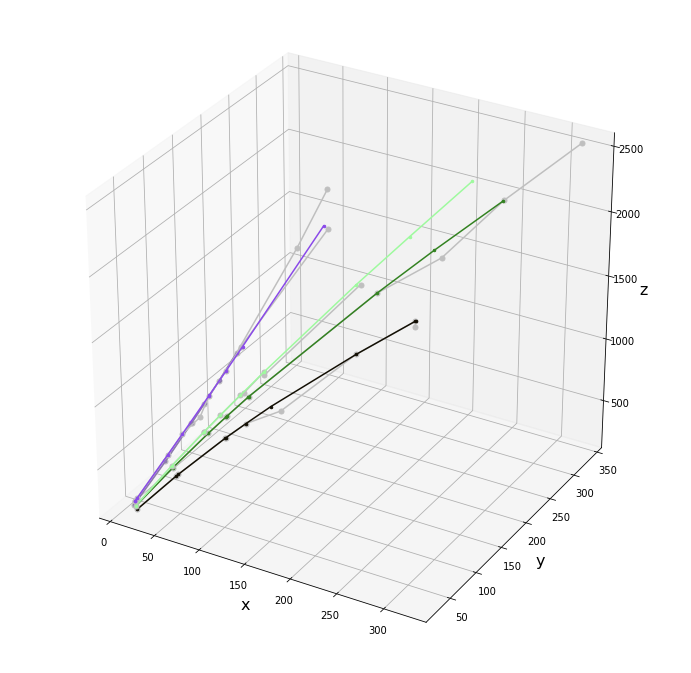

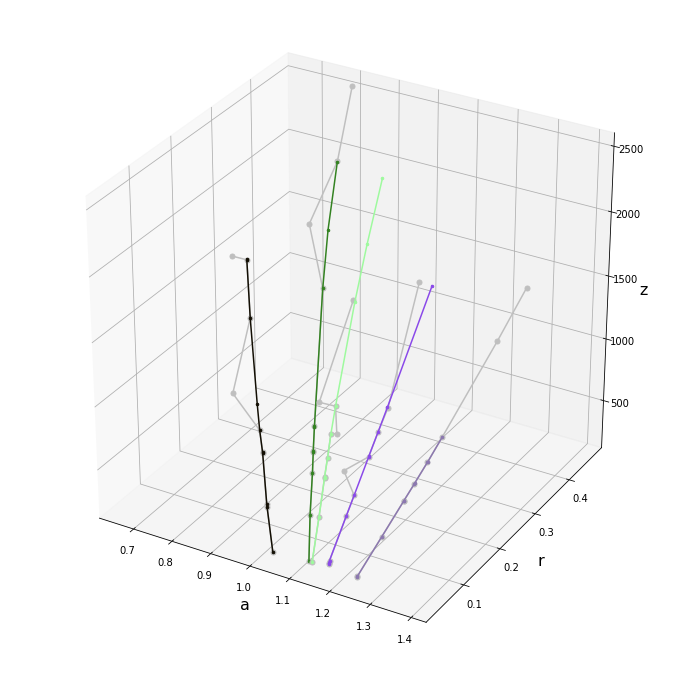

In [30]:
VISUALIZE_RESULTS = True
if VISUALIZE_RESULTS:
    draw_prediction(pred_truth[:,:,0:4], preds[:,:,0:4], 300, 305)